In [18]:
from Bio import AlignIO
from pathlib import Path
import os
import pandas as pd
import yaml

import seaborn as sn
import seaborn.objects as so
import matplotlib.pyplot as plt
import numpy as np

Process single source 

In [21]:
stats_path = Path(
    "/hits/fast/cme/bodynems/data/test_paper/test_benchout/b1/stats.parquet"
)

stats = pd.read_parquet(stats_path)
stats.query("method == 'dpos'")[["mean"]]
plot_df = stats.reset_index()[["dataset", "mean", "datatype", "method"]]
plot_df = plot_df.pivot(index=["dataset", "datatype"], columns="method", values="mean")
plot_df = plot_df.reset_index()
plot_df

method,dataset,datatype,dpos,pythia
0,s1,AA,0.067253,NaN
1,s2,AA,0.129453,NaN


Text(0.5, 0, 'Value')

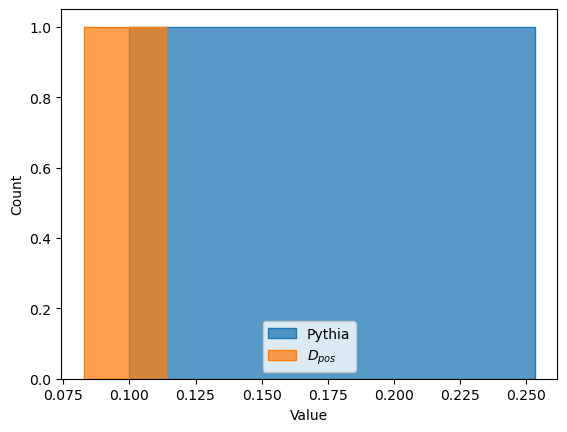

In [13]:
fig = plt.figure()
sn.histplot(plot_df, x="pythia", element="poly", label="Pythia")
sn.histplot(plot_df, x="dpos", element="poly", label="$D_{pos}$")
plt.legend()
plt.xlabel("Value")

In [ ]:
plot_df
# fig = plt.figure()
# sn.histplot(plot_df, x="pythia", element="poly", label="Pythia")
# sn.histplot(plot_df, x="dpos", element="poly", label="$D_{pos}$")
# plt.legend()
# plt.xlabel("Value")

sn.kdeplot(
    plot_df, x="dpos", y="pythia", hue="datatype", fill=True, alpha=0.7, bw_adjust=0.2
)

Process multiple sources 

In [50]:
sources = ["treebase_v1", "bali2dna", "bali2dnaf", "bali3", "ox", "prefab4", "sabre"]
dfs = []
for source in sources:
    stats_path = Path(
        # f"/hits/fast/cme/bodynems/data/test_paper/test_benchout/{source}/stats.parquet"
        f"/hits/fast/cme/bodynems/data/paper/{source}/stats.parquet"
    )

    dfs.append(pd.read_parquet(stats_path))

stats = pd.concat(dfs)
stats
stats.query("method == 'dpos'")[["mean"]]
plot_df = stats.reset_index()[["source", "dataset", "mean", "datatype", "method"]]
plot_df = plot_df.pivot(
    index=["source", "dataset", "datatype"], columns="method", values="mean"
)
plot_df = plot_df.reset_index()
plot_df["dpos"] = plot_df["dpos"] * 1.1
plot_df
tree_mask = plot_df["source"] == "treebase_v1"

dt_dfs = []
for dt in ["DNA", "AA"]:
    dt_mask = plot_df["datatype"] == dt

    dt_df = plot_df[tree_mask & dt_mask].copy()
    dt_df["source"] = "treebase_" + dt.lower()
    dt_dfs.append(dt_df)

dt_df = pd.concat(dt_dfs, axis=0, ignore_index=True)
plot_df = plot_df[~tree_mask]
plot_df = pd.concat([plot_df, dt_df], axis=0, ignore_index=True)
plot_df

method,source,dataset,datatype,dpos,pythia
0,bali2dna,1aab_ref1,DNA,0.263720,0.025117
1,bali2dna,1aboA_ref1,DNA,0.690157,0.088831
2,bali2dna,1aboA_ref2,DNA,0.283012,0.562824
3,bali2dna,1ac5_ref1,DNA,0.474230,0.028892
4,bali2dna,1ad2_ref1,DNA,0.274708,0.015250
...,...,...,...,...,...
6281,treebase_aa,28360_8.phy,AA,0.000863,0.517006
6282,treebase_aa,28407_0.phy,AA,0.136849,0.036124
6283,treebase_aa,616_1.phy,AA,0.002980,0.030112
6284,treebase_aa,667_0.phy,AA,0.007713,0.335361


In [53]:
plot_df.groupby("source").apply(lambda group: group.isna().mean())
plot_df.groupby("source").apply(lambda group: (group.datatype == "DNA").mean())
# plot_df["pythia"].isna()

/tmp/ipykernel_2231766/1112950505.py:1: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df.groupby("source").apply(lambda group: group.isna().mean())
/tmp/ipykernel_2231766/1112950505.py:2: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  plot_df.groupby("source").apply(lambda group: (group.datatype == "DNA").mean())


source
bali2dna        1.0
bali2dnaf       1.0
bali3           0.0
ox              0.0
prefab4         0.0
sabre           0.0
treebase_aa     0.0
treebase_dna    1.0
dtype: float64

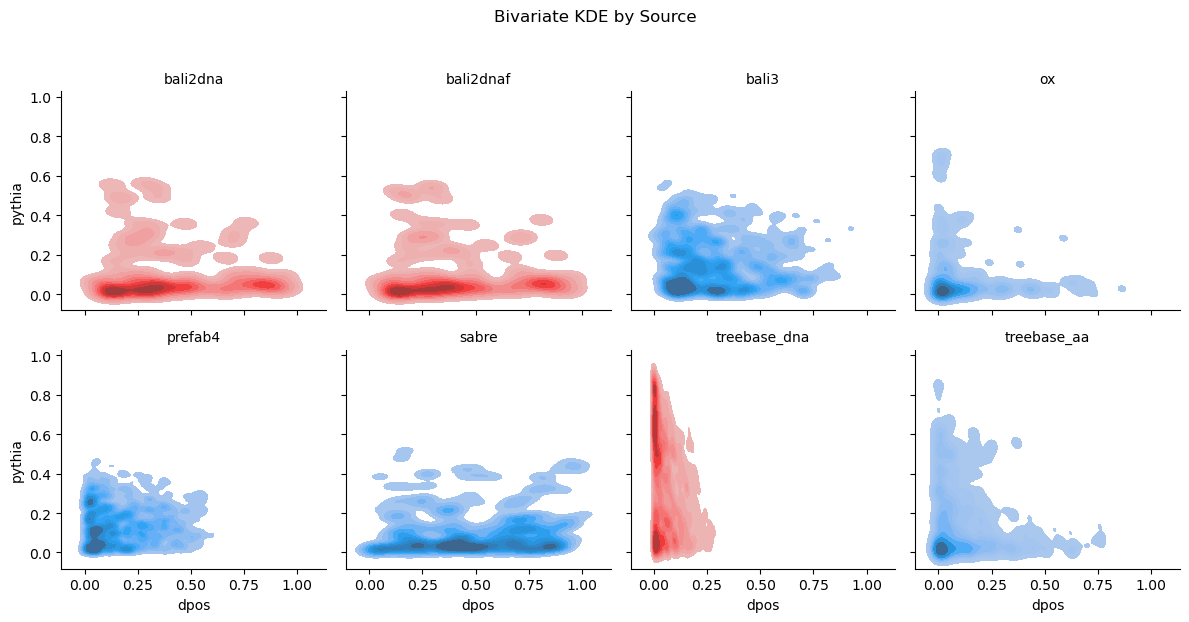

In [55]:
from functools import partial

ax_lims = [0, 1]
# sn.kdeplot(
#     plot_df, x="dpos", y="pythia", hue="source", fill=True, alpha=0.8, bw_adjust=0.9
# )
# sources = plot_df["source"].unique()
# n = np.ceil(np.sqrt(len(sources)))
# sn.scatterplot(plot_df, x="dpos", y="pythia", hue="source", style="source", alpha=0.75)
# plt.xlim(ax_lims)
# plt.ylim(ax_lims)

palette = {"DNA": "tab:red", "AA": "tab:blue"}

g = sn.FacetGrid(plot_df, col="source", col_wrap=4, height=3)
g.map_dataframe(
    partial(sn.kdeplot, bw_adjust=0.4, hue="datatype", palette=palette),
    x="dpos",
    y="pythia",
    fill=True,
    thresh=0.05,
)
g.set_titles(col_template="{col_name}")
g.figure.suptitle("Bivariate KDE by Source", y=1.03)
plt.tight_layout()
plt.show()

In [ ]:
sort_col = 1 / (1 / plot_df["dpos"] + 1 / plot_df["pythia"].fillna(0))
sort_idxs = sort_col.argsort()
plot_df.iloc[sort_idxs]

method,source,dataset,datatype,dpos,pythia
742,ox,_12s70,AA,0.023467,NaN
3291,treebase_dna,10264_3.phy,DNA,0.000000,0.607676
4890,treebase_dna,20429_6.phy,DNA,0.000000,0.000000
4889,treebase_dna,20429_3.phy,DNA,0.000000,0.000000
3257,treebase_dna,10200_4.phy,DNA,0.000000,0.685379
...,...,...,...,...,...
3134,sabre,twi_157,AA,0.797632,0.386677
3086,sabre,twi_068,AA,0.895184,0.423726
3107,sabre,twi_111,AA,0.978627,0.416012
3110,sabre,twi_114,AA,0.986578,0.444047


In [ ]:
# from aldiscore.scoring.pairwise import DPosDistance
# from aldiscore.datastructures.alignment import Alignment
# from aldiscore.datastructures.ensemble import Ensemble
# from aldiscore.scoring import pythia
from ensemblify.utils import infer_data_type

raxml_path = yaml.safe_load(open("../configs/general.yaml", "r"))["general"]["raxml"]
raxml_path = Path(raxml_path)
ens_dir = Path("/hits/fast/cme/bodynems/data/paper/treebase_v1/26669_21.phy/ensemble")
alignments = []
for msa_file in os.listdir(ens_dir):
    alignment = Alignment(AlignIO.read(ens_dir / msa_file, "fasta"))
    alignments.append(alignment)

ensemble = Ensemble(alignments)
print(infer_data_type(ensemble.dataset.records))
measure = DPosDistance(format="matrix")
score = measure.compute(ensemble)
print(score.round(2))

phylo = pythia.compute_pythia_difficulty(ensemble, raxml_path)
phylo
# AlignIO.read()

DNA


KeyboardInterrupt: 